In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from tqdm import tqdm
import torch
import zipfile
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:

df_agg = pd.read_csv('/content/drive/MyDrive/Final Project/machine_learning_TJ_v6_normalized_scaled_final.csv')

In [51]:
df_demo_1 = pd.read_csv('/content/drive/MyDrive/Final Project/machine_learning_TJ_v7_demographics (1).csv')

In [52]:
df_demo_2 = df_demo_1[['patient_id_deident','disch_date_indexed']]

df_int = pd.merge(df_demo_2, df_agg, on='patient_id_deident', how='inner')

df_int.fillna(-1)
print(df_int.shape)

(21312, 69)


In [53]:
df_int.to_csv('Data_agg.csv')

In [54]:

df_int.dropna()
y = df_int['disch_date_indexed'].astype(float)
X = np.array(df_int.drop('disch_date_indexed',axis =1))


In [55]:
y.fillna(y.median(), inplace = True)

In [56]:
y = np.array(y)
y = np.power(y,1/4)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.5235643870231119


In [58]:
def transform_back(x):
    return np.power(x, 4)

Text(0.5, 1.0, 'Predicted discharge date vs actual discharge date')

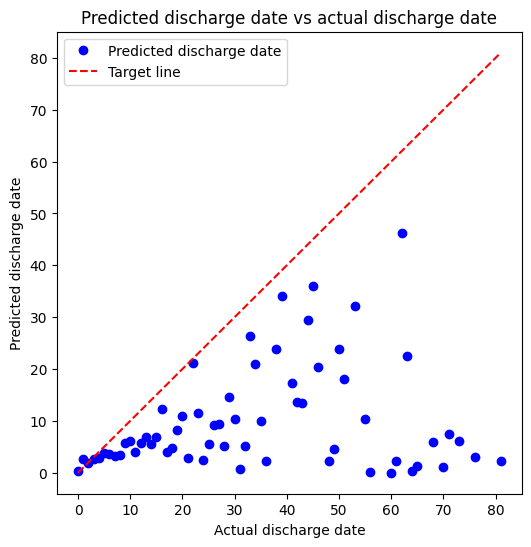

In [59]:
y_test_transform = np.power(y_test, 4)
y_pred_transform = np.power(y_pred, 4)
plt.figure(figsize=(6, 6))

# sort X_test and y_test by discharge date
predicted = []
actual = []
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transform)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale

    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:
        predicted.append(np.mean(transform_back(model.predict(X_test[indices].reshape(len(indices), -1)))))
        actual.append(actual_discharge_date)


# plot the predicted discharge date vs the actual discharge date
plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot(actual, actual, color='r', linestyle='--', label="Target line")
# vertical line for how many days the model was trained on
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")

In [44]:
y = df_int['disch_date_indexed'].astype(float)
X = np.array(df_int.drop('disch_date_indexed',axis =1))
y.fillna(y.median(), inplace = True)
y = np.array(y)
y = np.power(y,1/4)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network class
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(68, 128)  # First fully-connected layer

        self.fc3 = nn.Linear(128, 1)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Pass through first FC layer and ReLU activation
        x = self.fc3(x)  # Output layer
        return x

# Instantiate the model
model = FFNN()

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam optimizer with default parameters)
optimizer = optim.Adam(model.parameters())

# Convert input data to PyTorch tensors
X = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)

    # Compute loss
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 4885.3428
Epoch [20/100], Loss: 3289.4121
Epoch [30/100], Loss: 1986.7290
Epoch [40/100], Loss: 248.5438
Epoch [50/100], Loss: 12.4810
Epoch [60/100], Loss: 24.0374
Epoch [70/100], Loss: 25.2962
Epoch [80/100], Loss: 34.3759
Epoch [90/100], Loss: 11.3934
Epoch [100/100], Loss: 5.0961


In [46]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Forward pass on test data
with torch.no_grad():
    outputs_test = model(X_test_tensor)

# Compute test loss
loss_test = criterion(outputs_test, y_test_tensor)

print(f'Test Loss: {loss_test.item():.4f}')

Test Loss: 3.7633


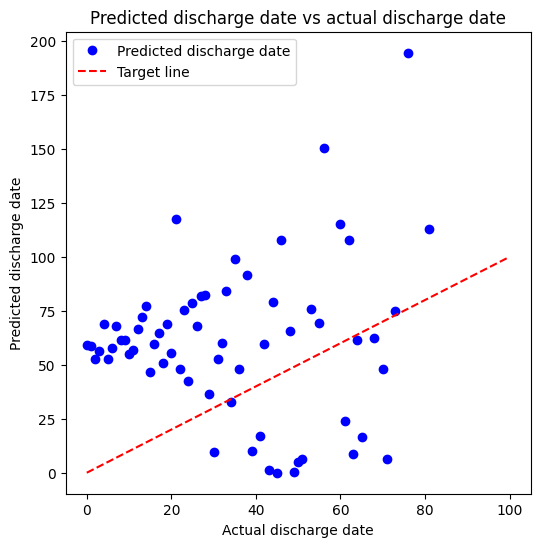

In [48]:
plt.figure(figsize=(6, 6))

predicted = []
actual = []
y_test_transformed = transform_back(y_test_tensor)
# round the discharge date to the nearest integer
y_test_transformed = np.round(y_test_transformed)
for actual_discharge_date in range(0, 100):
    # transform the predicted discharge date to the original scale
    indices = np.where(y_test_transformed == actual_discharge_date)[0]
    # append the average predicted discharge date for the patients with the same actual discharge date
    if len(indices) > 0:
        predicted.append(np.mean(transform_back(model(X_test_tensor.reshape(X_test_tensor.shape[0], -1)[indices]).detach().cpu().numpy())))
        actual.append(actual_discharge_date)

plt.plot(actual, predicted, 'o', color='b', label="Predicted discharge date")
plt.plot([0, 100], [0, 100], color='r', linestyle='--', label="Target line")
plt.legend()
plt.xlabel("Actual discharge date")
plt.ylabel("Predicted discharge date")
plt.title("Predicted discharge date vs actual discharge date")
plt.show()

In [12]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

# Hyperparameters
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.2

# Instantiate the model
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam optimizer with default parameters)
optimizer = optim.Adam(model.parameters())

# Convert input data to PyTorch tensors
X = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

# Reshape input data to match the expected shape (batch_size, seq_length, input_size)
X = X.unsqueeze(2)  # Add an extra dimension for the input size

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)

    # Compute loss
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Due to the unavailability of RAM in the colab, we are not able to run the LSTM model.